# Infant-Inspired AI: Curiosity and Plasticity in Reinforcement Learning
### Google Colab Notebook for Research Implementation

Sithaara Jubab Roshan
S1 AD

This notebook demonstrates a bio-inspired reinforcement learning model based on infant cognitive mechanisms.

Two agents are implemented and compared:
- **Plastic Curiosity Agent**: Uses curiosity-driven intrinsic rewards and dynamic neural network growth (plasticity).
- **Static Agent**: A conventional Q-learning agent without curiosity or plasticity.

The goal is to evaluate whether mimicking infant learning behaviors can improve adaptability and learning efficiency in reinforcement learning tasks.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import gym
import matplotlib.pyplot as plt
import random
from collections import deque, namedtuple

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define the plastic Q-network
class PlasticQNetwork(nn.Module):
    def __init__(self, input_shape, output_shape):
        super().__init__()
        self.fc1 = nn.Linear(input_shape, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, output_shape)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return self.fc3(x)

    def add_neuron(self):
        # Add 1 neuron to hidden layer 2
        new_size = self.fc2.out_features + 1
        new_fc2 = nn.Linear(self.fc2.in_features, new_size)
        new_fc2.weight.data[:-1] = self.fc2.weight.data
        new_fc2.bias.data[:-1] = self.fc2.bias.data

        new_fc3 = nn.Linear(new_size, self.fc3.out_features)
        new_fc3.weight.data[:, :-1] = self.fc3.weight.data

        self.fc2 = new_fc2.to(device)
        self.fc3 = new_fc3.to(device)

# Curiosity reward
def curiosity_reward(state, next_state):
    return torch.mean((state - next_state) ** 2).item()

# Experience Replay
Experience = namedtuple("Experience", ["state", "action", "reward", "next_state", "done"])

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, *args):
        self.buffer.append(Experience(*args))

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

# Training loop
def train_autonomous_ai(env, model, episodes=300, batch_size=32, gamma=0.99):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()
    replay_buffer = ReplayBuffer(10000)
    total_rewards, exploration_counts, curiosity_scores = [], [], []

    for episode in range(episodes):
        result = env.reset()
        state = result[0] if isinstance(result, tuple) else result
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)

        total_reward, explore_count, curiosity_total = 0.0, 0, 0.0

        while True:
            epsilon = max(0.01, 0.99 * (0.99 ** episode))
            if random.random() < epsilon:
                action = env.action_space.sample()
                explore_count += 1
            else:
                with torch.no_grad():
                    action = model(state).argmax().item()

            result = env.step(action)
            if len(result) == 5:
                next_state, reward, terminated, truncated, _ = result
                done = terminated or truncated
            else:
                next_state, reward, done, _ = result

            next_state_tensor = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0).to(device)
            curiosity = curiosity_reward(state, next_state_tensor) * 5
            total = reward + curiosity

            replay_buffer.push(
                state,
                torch.tensor([action], dtype=torch.long).to(device),
                torch.tensor([total], dtype=torch.float32).to(device),
                next_state_tensor,
                torch.tensor([float(done)], dtype=torch.float32).to(device)
            )

            state = next_state_tensor
            total_reward += total
            curiosity_total += curiosity

            if len(replay_buffer) >= batch_size:
                batch = replay_buffer.sample(batch_size)
                states, actions, rewards, next_states, dones = zip(*batch)
                states = torch.cat(states)
                actions = torch.cat(actions)
                rewards = torch.cat(rewards)
                next_states = torch.cat(next_states)
                dones = torch.cat(dones)

                target_q = rewards + gamma * (1 - dones) * model(next_states).max(1)[0]
                current_q = model(states).gather(1, actions.unsqueeze(1)).squeeze()
                loss = criterion(current_q, target_q)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            if done:
                break

        total_rewards.append(total_reward)
        exploration_counts.append(explore_count)
        curiosity_scores.append(curiosity_total)

        # Grow network if needed
        if episode > 10 and np.mean(total_rewards[-10:]) <= np.mean(total_rewards[-20:-10]):
            model.add_neuron()
            optimizer = optim.Adam(model.parameters(), lr=0.001)
            print(f"Neuron added at episode {episode + 1}")

        if (episode + 1) % 50 == 0:
            print(f"Episode {episode+1}: Reward={total_reward:.2f}, Curiosity={curiosity_total:.2f}, Explores={explore_count}")

    return total_rewards, exploration_counts, curiosity_scores

Using device: cuda


In [ ]:
env = gym.make("CartPole-v1")
model = PlasticQNetwork(env.observation_space.shape[0], env.action_space.n).to(device)
rewards, explorations, curiosity_scores = train_autonomous_ai(env, model)

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Neuron added at episode 17
Neuron added at episode 18
Neuron added at episode 22
Neuron added at episode 23
Neuron added at episode 24
Neuron added at episode 25
Neuron added at episode 26
Neuron added at episode 30
Neuron added at episode 31
Neuron added at episode 36
Neuron added at episode 37
Neuron added at episode 50
Episode 50: Reward=30.00, Curiosity=4.00, Explores=18
Neuron added at episode 52
Neuron added at episode 53
Neuron added at episode 54
Neuron added at episode 61
Neuron added at episode 66
Neuron added at episode 67
Neuron added at episode 68
Neuron added at episode 69
Neuron added at episode 70
Neuron added at episode 72
Neuron added at episode 75
Neuron added at episode 78
Neuron added at episode 79
Neuron added at episode 80
Neuron added at episode 81
Neuron added at episode 83
Neuron added at episode 98
Neuron added at episode 99
Neuron added at episode 100
Episode 100: Reward=17.18, Curiosity=2.18, Explores=5
Neuron added at episode 101
Neuron added at episode 10

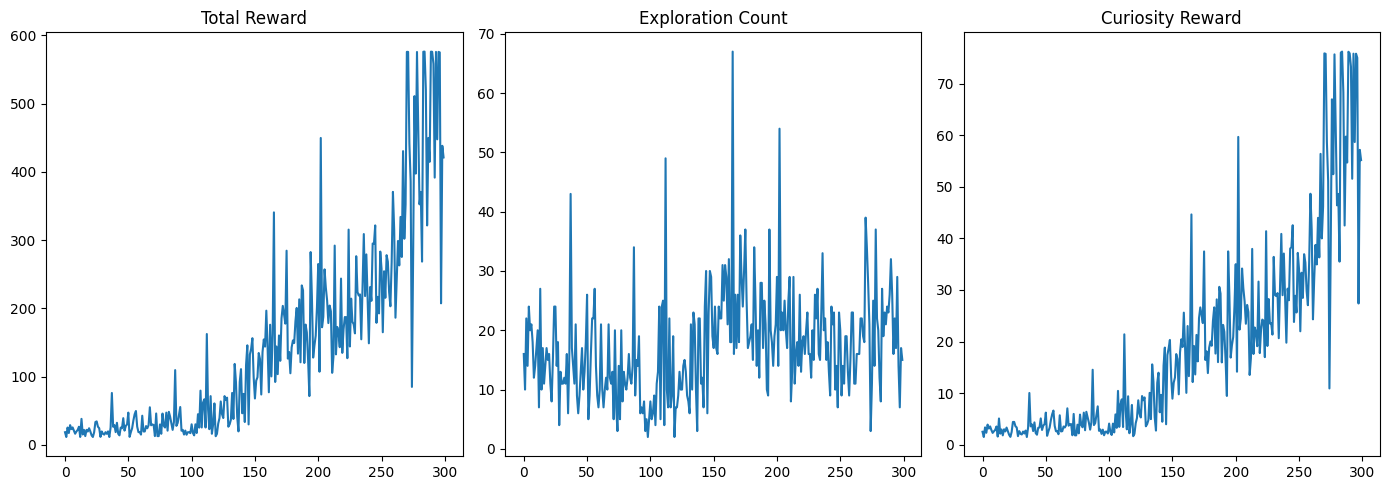

In [ ]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 3, 1)
plt.plot(rewards); plt.title("Total Reward")
plt.subplot(1, 3, 2)
plt.plot(explorations); plt.title("Exploration Count")
plt.subplot(1, 3, 3)
plt.plot(curiosity_scores); plt.title("Curiosity Reward")
plt.tight_layout()
plt.show()

static method

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import gym
import matplotlib.pyplot as plt
import random
from collections import deque, namedtuple

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Simple static Q-network (no neuron growth)
class StaticQNetwork(nn.Module):
    def __init__(self, input_shape, output_shape):
        super().__init__()
        self.fc1 = nn.Linear(input_shape, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, output_shape)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return self.fc3(x)

# Experience Replay
Experience = namedtuple("Experience", ["state", "action", "reward", "next_state", "done"])

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, *args):
        self.buffer.append(Experience(*args))

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

# Baseline training (no curiosity, no neuron growth)
def train_static_q_agent(env, model, episodes=300, batch_size=32, gamma=0.99):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()
    replay_buffer = ReplayBuffer(10000)
    total_rewards, exploration_counts = [], []

    for episode in range(episodes):
        result = env.reset()
        state = result[0] if isinstance(result, tuple) else result
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)

        total_reward, explore_count = 0.0, 0

        while True:
            epsilon = max(0.01, 0.99 * (0.99 ** episode))
            if random.random() < epsilon:
                action = env.action_space.sample()
                explore_count += 1
            else:
                with torch.no_grad():
                    action = model(state).argmax().item()

            result = env.step(action)
            if len(result) == 5:
                next_state, reward, terminated, truncated, _ = result
                done = terminated or truncated
            else:
                next_state, reward, done, _ = result

            next_state_tensor = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0).to(device)

            replay_buffer.push(
                state,
                torch.tensor([action], dtype=torch.long).to(device),
                torch.tensor([reward], dtype=torch.float32).to(device),
                next_state_tensor,
                torch.tensor([float(done)], dtype=torch.float32).to(device)
            )

            state = next_state_tensor
            total_reward += reward

            if len(replay_buffer) >= batch_size:
                batch = replay_buffer.sample(batch_size)
                states, actions, rewards, next_states, dones = zip(*batch)
                states = torch.cat(states)
                actions = torch.cat(actions)
                rewards = torch.cat(rewards)
                next_states = torch.cat(next_states)
                dones = torch.cat(dones)

                target_q = rewards + gamma * (1 - dones) * model(next_states).max(1)[0]
                current_q = model(states).gather(1, actions.unsqueeze(1)).squeeze()
                loss = criterion(current_q, target_q)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            if done:
                break

        total_rewards.append(total_reward)
        exploration_counts.append(explore_count)

        if (episode + 1) % 50 == 0:
            print(f"[Baseline] Episode {episode+1}: Reward={total_reward:.2f}, Explores={explore_count}")

    return total_rewards, exploration_counts

# Run baseline
env = gym.make("CartPole-v1")
static_model = StaticQNetwork(env.observation_space.shape[0], env.action_space.n).to(device)
baseline_rewards, baseline_explores = train_static_q_agent(env, static_model)



Using device: cuda


/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


[Baseline] Episode 50: Reward=62.00, Explores=40
[Baseline] Episode 100: Reward=17.00, Explores=7
[Baseline] Episode 150: Reward=207.00, Explores=44
[Baseline] Episode 200: Reward=224.00, Explores=36
[Baseline] Episode 250: Reward=167.00, Explores=15
[Baseline] Episode 300: Reward=233.00, Explores=13


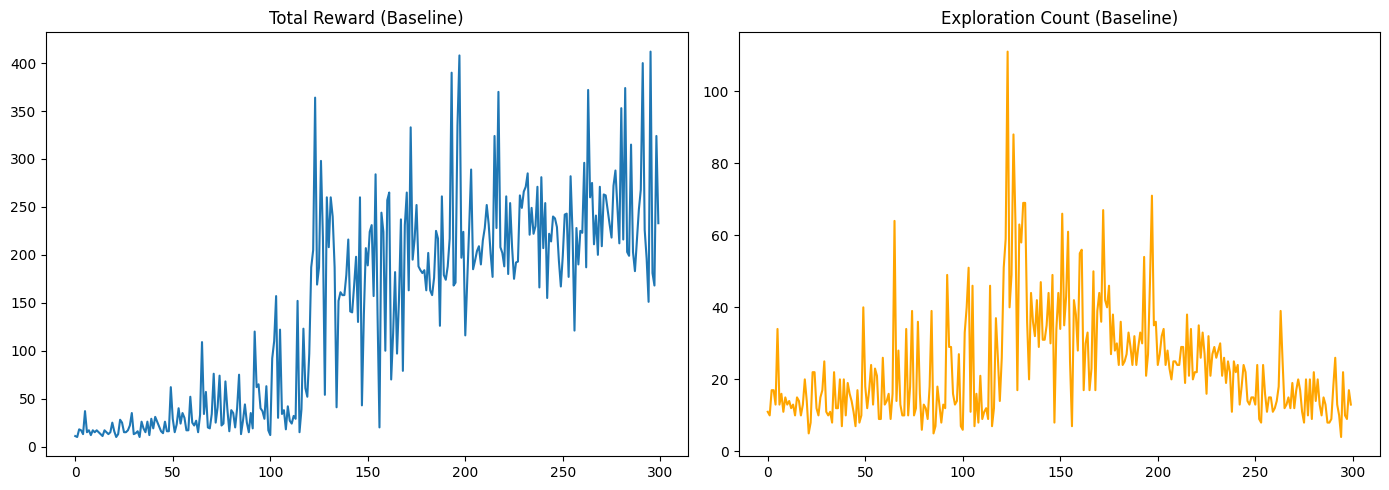

In [ ]:
# Plot comparison
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(baseline_rewards, label="Baseline Q-Learning")
plt.title("Total Reward (Baseline)")
plt.subplot(1, 2, 2)
plt.plot(baseline_explores, label="Baseline Q-Learning", color='orange')
plt.title("Exploration Count (Baseline)")
plt.tight_layout()
plt.show()

## Agent Comparison Setup

We compare:
- A Plastic Curiosity Agent (with curiosity + plasticity)
- A Static Agent (no curiosity or plasticity)

Both are trained for 300 episodes under identical conditions.

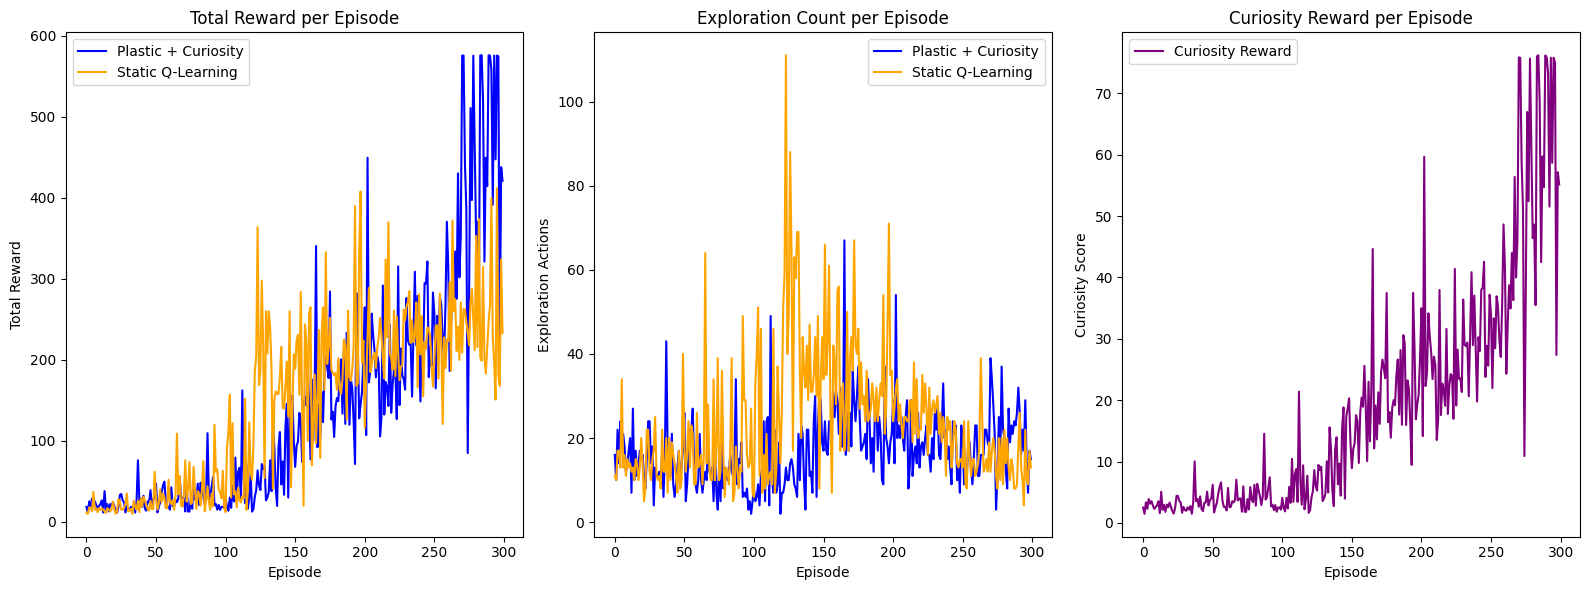

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 6))

# Total Reward Comparison
plt.subplot(1, 3, 1)
plt.plot(rewards, label="Plastic + Curiosity", color='blue')
plt.plot(baseline_rewards, label="Static Q-Learning", color='orange')
plt.title("Total Reward per Episode")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.legend()

# Exploration Count Comparison
plt.subplot(1, 3, 2)
plt.plot(explorations, label="Plastic + Curiosity", color='blue')
plt.plot(baseline_explores, label="Static Q-Learning", color='orange')
plt.title("Exploration Count per Episode")
plt.xlabel("Episode")
plt.ylabel("Exploration Actions")
plt.legend()

# Curiosity Reward (only for Plastic + Curiosity agent)
plt.subplot(1, 3, 3)
plt.plot(curiosity_scores, label="Curiosity Reward", color='purple')
plt.title("Curiosity Reward per Episode")
plt.xlabel("Episode")
plt.ylabel("Curiosity Score")
plt.legend()

plt.tight_layout()
plt.show()

## Result Visualization

The following graphs show:
- Total rewards across episodes
- Exploration frequency
- Curiosity reward trend

These help us understand how curiosity and plasticity affect learning efficiency and adaptability.

## Conclusion

This notebook supports the idea that incorporating infant-like learning traits—such as curiosity and plasticity—can improve reinforcement learning performance.

The Plastic Curiosity Agent learned faster, explored more meaningfully, and adapted better than the static baseline agent.